# 8. Annex 2 - Searching with the EMSLP dataset

## 8.1 Dataset file
In this annex, we will do the same exercise with the EMSLP dataset (https://www.metoffice.gov.uk/hadobs/emslp/) which is more "lightweight", and so needs less computational resources to train the model (Neal et al. (2016) A flexible approach to defining weather patterns and their application in weather forecasting over Europe, Met. Apps. 23, 389-400). Download the following file and put the ascii file (after gunzip) in a data submap of your working directory. 
- Daily mean sea level pressure (MSL) [hPa*100]: https://www.metoffice.gov.uk/hadobs/emslp/data/emulate_3.2_1850-2003.asc.gz

The 25x10 gridpoints are covering the North Atlantic and Europe (70W-50E, 25N-70N) for 56247 days (1850-2003). 
To get rid of the double spaces, execute the following command: 



In [1]:
!tr -s " " < data/emulate_3.2_1850-2003.asc > data/emslp.asc

As for the autoencoder we want the number of gridpoints equal to a power of 2 (in latitude and logitude direction), we will skip the 2 most north rows and the most east column. For serving as input to our neural network, we also scale the dataset.

In [2]:
import numpy as np

N = 6247 # nbr in test set

file="data/emslp"
with open(file+".asc") as f:
    lines = f.readlines()
x = []
y = []
for i in range(0, len(lines)):
    if i % 11 == 0:  
        y.append(lines[i][1:-1])
    elif ((i-1) % 11 != 0) and ((i-2) % 11 != 0):             # 2 bovenste rijen niet
        x.append([int(j) for j in lines[i][1:-1].split(" ")]) 

x = np.array(x)
x = x [:,1:]                        # 1ste kolom niet
x = x - 94000
x = x.astype('float32') / 13000.    # min=94000 , max=107000 -> x tussen 0 en 1
x = x.reshape(x.shape[0]//8,8,24,1) # grid: 8 * 24 points with 1 channel (Keras)
print(x.shape)
y = np.array(y)
print(len(y),"days: ",y[0]," -> ", y[-1])
np.save(file+".npy", x)
np.save(file+"_dates.npy", y)
i = np.argsort(np.random.random(x.shape[0]))
x = x[i]
y = y[i]

x_test = x[:N]
y_test = y[:N]
x_train = x[N:]
y_train = y[N:]
np.save(file+"_test.npy", x_test)
np.save(file+"_train.npy", x_train)

(56247, 8, 24, 1)
56247 days:  1850 1 1  ->  2003 12 31


## 8.2 Create the model

In [6]:
import numpy as np
import keras
from keras import layers
from keras.models import save_model
from keras.callbacks import TensorBoard

file="data/emslp"

# Encoder (8,24,1) - > (2,6,2)
input = keras.Input(shape=(8, 24, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)

# Decoder (2,6,2) -> (8,24,1)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='MSE')
print(autoencoder.summary())

x_train = np.load(file+"_train.npy")
x_test = np.load(file+"_test.npy")

autoencoder.fit(x_train, x_train,
                epochs=35,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

autoencoder.save("data/emslp.h5")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8, 24, 1)]        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 24, 32)         320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 12, 32)        0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 12, 8)          2312      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 6, 8)          0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 2, 6, 2)           146 

## 8.3 Compressing the EMSLP dataset


In [3]:
import numpy as np
from keras.models import load_model
from keras.models import Model

file="data/emslp"
 
# load model
autoencoder = load_model(file+".h5")

# keep only encoding part
compress = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-6].output)
#compress.summary()
compress.save(file+"_compress.h5")

# load data
x_in = np.load(file+".npy")

# Compress
x_compress = compress.predict(x_in)
np.save(file+"_compressed.npy", x_compress)

2022-06-22 09:02:21.276766: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## 8.4 Search in the cmpressed EMSLP dataset

Index 	 Date 		 Compressed Distance 	 Mean Isobar Distance [hPa]
51158 	 1990 1 25 	 0.0 	 0.0
11693 	 1882 1 6 	 0.13126398622989655 	 562.1739280957107
51159 	 1990 1 26 	 0.1361614167690277 	 416.1396543706181
49694 	 1986 1 22 	 0.13805893063545227 	 434.7097959452084
50822 	 1989 2 23 	 0.1393018662929535 	 509.7699119661656
40513 	 1960 12 3 	 0.14158888161182404 	 574.4488937981629
51157 	 1990 1 24 	 0.14360034465789795 	 465.35037801702765
50404 	 1988 1 2 	 0.14543834328651428 	 505.4264647322926
12443 	 1884 1 26 	 0.14551609754562378 	 534.667226119707
28151 	 1927 1 29 	 0.14741337299346924 	 454.0241076238481
54416 	 1998 12 27 	 0.14818251132965088 	 441.8955233311991
51503 	 1991 1 5 	 0.14931045472621918 	 471.0140065549119
49693 	 1986 1 21 	 0.1508190929889679 	 543.864764065897
39063 	 1956 12 14 	 0.15195190906524658 	 498.0045325822407
49692 	 1986 1 20 	 0.15243379771709442 	 602.5397118668234
51501 	 1991 1 3 	 0.15324491262435913 	 474.03512292627624
16097 	 18

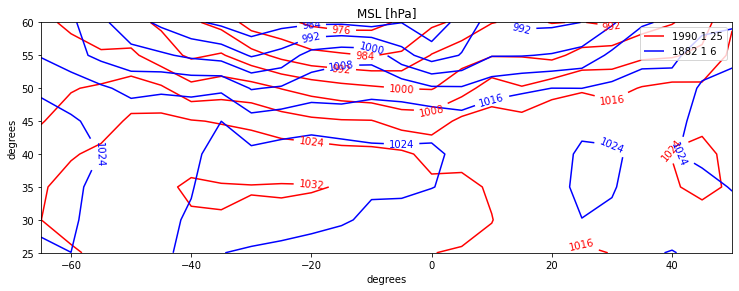

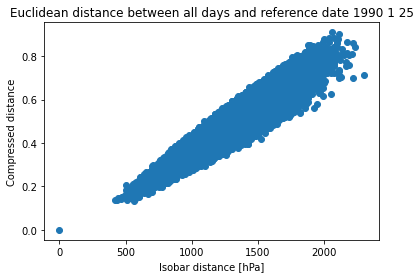

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from isoplot import isoplot

# date
date = "1990 1 25"
#date = "1953 1 31"
#date = "1976 1 2"
#date = "1976 8 1"
#date = "2003 8 10"

# load data
file="data/emslp"
isobar = np.load(file+".npy")
isobar = isobar.reshape(isobar.shape[0],isobar.shape[1]*isobar.shape[2])
compressed = np.load(file+"_compressed.npy")
compressed = compressed.reshape(compressed.shape[0],compressed.shape[1]*compressed.shape[2]*compressed.shape[3])
dates = np.load(file+"_dates.npy")
isobar = isobar * 13000. + 94000.       # omzetten naar Pa

# calculate distances
compressed_dist = np.zeros(dates.shape[0])
isobar_dist = np.zeros(dates.shape[0])
date_index = np.where(dates == date)
compressed_ref = compressed[date_index]
isobar_ref = isobar[date_index]
for i in range(compressed.shape[0]):
    compressed_dist[i] = np.linalg.norm(compressed[i]-compressed_ref)
    isobar_dist[i] = np.linalg.norm((isobar[i]-isobar_ref))/np.sqrt(isobar.shape[1])

# smallest distances
smallest_compressed = np.argsort(compressed_dist)[:25]
print("Index","\t","Date","\t\t","Compressed Distance","\t","Mean Isobar Distance [hPa]")
for i in smallest_compressed:
    print(i,"\t",dates[i],"\t",compressed_dist[i],"\t",isobar_dist[i])

# plot original and date with smallest distance
min_dist_index = smallest_compressed[1]  # for 2nd smallest take 2
isoplot((isobar[date_index]).reshape(8,24),isobar[min_dist_index].reshape(8,24),date,dates[min_dist_index])

# scatter plot
plt.scatter(isobar_dist, compressed_dist)
plt.xlabel("Isobar distance [hPa]")
plt.ylabel("Compressed distance")
plt.title("Euclidean distance between all days and reference date " + date)
plt.show()